In [2]:
!.\venv\Scripts\activate

In [3]:
import os

import numpy as np
import pandas as pd
import pickle 

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Plots
import matplotlib.pyplot as plt

# Prerocessing for FEDOT
from fedot.core.data.data import InputData
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.api.main import Fedot
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# FEDOT 
from fedot.core.pipelines.pipeline import Pipeline
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode

import logging
logging.raiseExceptions = False

In [4]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df.sort_index()


омепразол_stat_control  надропарин кальция_stat_control  \
case    t_point                                                            
GACAAcY 0                             1                                1   
        1                             1                                1   
        2                             1                                1   
        3                             1                                1   
GACAAnf 0                             1                                1   
...                                 ...                              ...   
GACBB;O 0                             0                                0   
        1                             0                                0   
GACXAAB 0                             1                                0   
        1                             1                                0   
        2                             1                                0   

                 эзомепразол_stat_control  амлодипин_stat_control  \
case    t_point                                                     
GACAAcY 0                               1                       1   
        1                               1                       1   
        2                               1                       1   
        3                               1                       1   
GACAAnf 0                               1                       1   
...                                   ...                     ...   
GACBB;O 0                               0                       1   
        1                               0                       1   
GACXAAB 0                               1                       1   
        1                               1                       1   
        2                               1                       1   

                 амброксол_stat_control  домперидон_stat_control  \
case    t_point                                                    
GACAAcY 0                             1                        1   
        1                             1                        1   
        2                             1                        1   
        3                             1                        1   
GACAAnf 0                             1                        1   
...                                 ...                      ...   
GACBB;O 0                             1                        0   
        1                             1                        0   
GACXAAB 0                             0                        1   
        1                             0                        1   
        2                             0                        1   

                 меброфенин_stat_control  технеций_stat_control  \
case    t_point                                                   
GACAAcY 0                              1                      1   
        1                              1                      1   
        2                              1                      1   
        3                              1                      1   
GACAAnf 0                              1                      1   
...                                  ...                    ...   
GACBB;O 0                              0                      0   
        1                              0                      0   
GACXAAB 0                              1                      1   
        1                              1                      1   
        2                              1                      1   

                 мометазон_stat_control  бисопролол_stat_control  ...  \
case    t_point                                                   ...   
GACAAcY 0                             1                        1  ...   
        1                             1                        1  ...   
        2                             1                        1  ...   
        

In [5]:
dinam_fact_df = df.iloc[:,29:42]
dinam_fact_df = dinam_fact_df.sort_values(["case", "t_point"])

In [6]:
dinam_fact_df.columns

Index(['Температура_dinam_fact', 'Лимфоциты#_dinam_fact', 'АСТ_dinam_fact',
       'ЧСС_dinam_fact', 'ЧДД_dinam_fact', 'Билирубин общий_dinam_fact',
       'MPV- Средн.объем тромбоцитов_dinam_fact', 'PCT- Тромбокрит_dinam_fact',
       'Лимфоциты%_dinam_fact', 'снижение_сознания_dinam_fact',
       'Cтепень тяжести по КТ_dinam_fact', 'Лактатдегидрогеназа_dinam_fact',
       'PDW- Индекс расп.по объему тр._dinam_fact'],
      dtype='object')

Lets take window size=3 and now we will use SHIFT to make more train data

In [78]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
imp = IterativeImputer(estimator=LinearRegression(),
                       missing_values=np.nan, max_iter=10, imputation_order='roman', random_state=0)
df_imputed = imp.fit_transform(dinam_fact_df)
df_imputed

array([[ 36.7 ,   1.93,  27.9 , ...,   2.  , 245.  ,  14.  ],
       [ 36.3 ,   2.  ,  25.7 , ...,   2.  , 315.  ,  12.8 ],
       [ 36.6 ,   2.13,  32.  , ...,   5.  , 290.  ,  13.5 ],
       ...,
       [ 36.5 ,   1.11,  21.8 , ...,   1.  , 219.  ,  11.7 ],
       [ 36.9 ,   1.6 ,  60.8 , ...,   5.  , 335.  ,  13.4 ],
       [ 36.6 ,   3.45,  17.2 , ...,   5.  , 279.  ,  11.6 ]])

In [49]:
dinam_fact_df["АСТ_dinam_fact"]

Температура_dinam_fact  Лимфоциты#_dinam_fact  \
case    t_point                                                  
GACAAcY 0                          36.7                   1.93   
        1                          36.3                   2.00   
        2                          36.6                   2.13   
        3                          36.5                   2.12   
GACAAnf 0                           NaN                   1.21   
...                                 ...                    ...   
GACBB;O 0                          36.9                   1.22   
        1                          36.5                   1.65   
GACXAAB 0                          36.5                   1.11   
        1                          36.9                   1.60   
        2                          36.6                   3.45   

                 АСТ_dinam_fact  ЧСС_dinam_fact  ЧДД_dinam_fact  \
case    t_point                                                   
GACAAcY 0                 27.90            74.0            24.0   
        1                 25.70            71.0            19.0   
        2                 32.00             NaN            18.0   
        3                 27.00            71.0            18.0   
GACAAnf 0                 20.70            55.0            22.0   
...                         ...             ...             ...   
GACBB;O 0                 22.34            54.0            18.0   
        1                244.03             NaN            17.0   
GACXAAB 0                 21.80             NaN             NaN   
        1                 60.80            75.0            16.0   
        2                 17.20             NaN            15.0   

                 Билирубин общий_dinam_fact  \
case    t_point                               
GACAAcY 0                             15.30   
        1                             12.10   
        2                               NaN   
        3                               NaN   
GACAAnf 0                              7.80   
...                                     ...   
GACBB;O 0                              1.43   
        1                              3.78   
GACXAAB 0                              4.50   
        1                              1.10   
        2                              9.30   

                 MPV- Средн.объем тромбоцитов_dinam_fact  \
case    t_point                                            
GACAAcY 0                                           11.2   
        1                                           10.6   
        2                                           11.0   
        3                                           11.4   
GACAAnf 0                                            8.1   
...                                                  ...   
GACBB;O 0                                            7.0   
        1                                            7.2   
GACXAAB 0                                           10.6   
        1                                           10.8   
        2                                           10.0   

                 PCT- Тромбокрит_dinam_fact  Лимфоциты%_dinam_fact  \
case    t_point                                                      
GACAAcY 0                             0.100                   48.3   
        1                             0.160                   30.7   
        2                             0.190                   23.1   
        3                             0.100                   24.1   
GACAAnf 0                             0.201                   24.1   
...                                     ...                    ...   
GACBB;O 0                             0.134                   33.0   
        1                             0.210                   41.2   
GACXAAB 0                             0.200                   18.8   
        1                             0.270                   12.9   
        2                             0.280          

In [69]:
def split_windows(df, window=3):
    X, y = [], []
    for i in df.index.levels[0]:
        len_ts = dinam_fact_df.groupby(["case"]).size()[i]
        if len_ts < window+1:
            continue
        X.append(df.loc[(i, 0): (i, window-1)].to_numpy().reshape(39))
        y.append(df.loc[(i, window)]["Температура_dinam_fact"])
    return np.array(X), np.array(y)
X, y = split_windows(dinam_fact_df)

In [70]:
display(X)
y

array([[ 36.7 ,   1.93,  27.9 , ...,   5.  , 290.  ,  13.5 ],
       [ 36.6 ,   1.09, 225.4 , ...,   5.  , 342.  ,  12.2 ],
       [ 36.4 ,   1.08,  10.9 , ...,   5.  , 227.  ,  14.6 ],
       ...,
       [ 37.4 ,   1.22,  35.5 , ...,   5.  , 286.  ,  11.  ],
       [ 36.6 ,   2.  ,  41.89, ...,   5.  , 342.09,  16.6 ],
       [ 36.7 ,   0.62,  42.2 , ...,   5.  , 386.  ,  11.6 ]])

array([36.5, 36.6, 36.5, 36.8,  nan, 36.5, 36.5, 36.4,  nan, 36.4, 36.6,
       36.5, 36.6, 36.5,  nan,  nan,  nan,  nan, 36.7, 36.5, 36.5, 36.5,
       36.5,  nan, 36.6, 36.5, 36.5, 36.5, 36.8, 36.6,  nan,  nan,  nan,
        nan,  nan,  nan,  nan, 36.6,  nan,  nan,  nan,  nan, 36.3, 36.4,
       36.3, 36.5, 36.5,  nan, 36.5, 36.6, 36.6, 36.5, 36.5, 36.9,  nan,
       36.4,  nan,  nan, 36.2, 36.5,  nan, 36.7,  nan, 36.6, 36.4,  nan,
        nan,  nan, 36.9,  nan, 36.7, 36.7, 36.6, 36.2, 36.5,  nan, 36.6,
       36.4,  nan, 36.8,  nan, 36.6, 36.7,  nan, 36.6,  nan, 36.7, 36.4,
       36.6, 36.5, 36.4, 36.6, 36.4, 36.4, 36.3, 36.4, 36.6, 36.5, 36.5,
        nan, 36.5,  nan,  nan,  nan,  nan, 36.2,  nan, 36.4,  nan, 36.3,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan, 36.7,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

2022-11-01 12:31:47,612 - ApiComposer - Initial pipeline was fitted in 0.4 sec.
2022-11-01 12:31:47,617 - ApiComposer - AutoML configured. Parameters tuning: True Time limit: 10 min Set of candidate models: ['adareg', 'dtreg', 'gbr', 'knnreg', 'lasso', 'lgbmreg', 'linear', 'rfr', 'ridge', 'sgdr', 'svr', 'treg', 'scaling', 'normalization', 'pca', 'fast_ica', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'isolation_forest_reg']
2022-11-01 12:31:47,628 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2022-11-01 12:37:39,782 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [05:52<?, ?gen/s]

2022-11-01 12:37:39,787 - ApiComposer - Hyperparameters tuning started with 4 min. timeout


  0%|          | 214/100000 [04:08<32:09:04,  1.16s/trial, best loss: 0.19493187377920812]
2022-11-01 12:41:50,921 - ApiComposer - Hyperparameters tuning finished
2022-11-01 12:41:51,231 - ApiComposer - Model generation finished
2022-11-01 12:41:51,357 - FEDOT logger - Final pipeline was fitted
2022-11-01 12:41:51,360 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 4, 'nodes': [rfr, scaling, normalization, pca]}


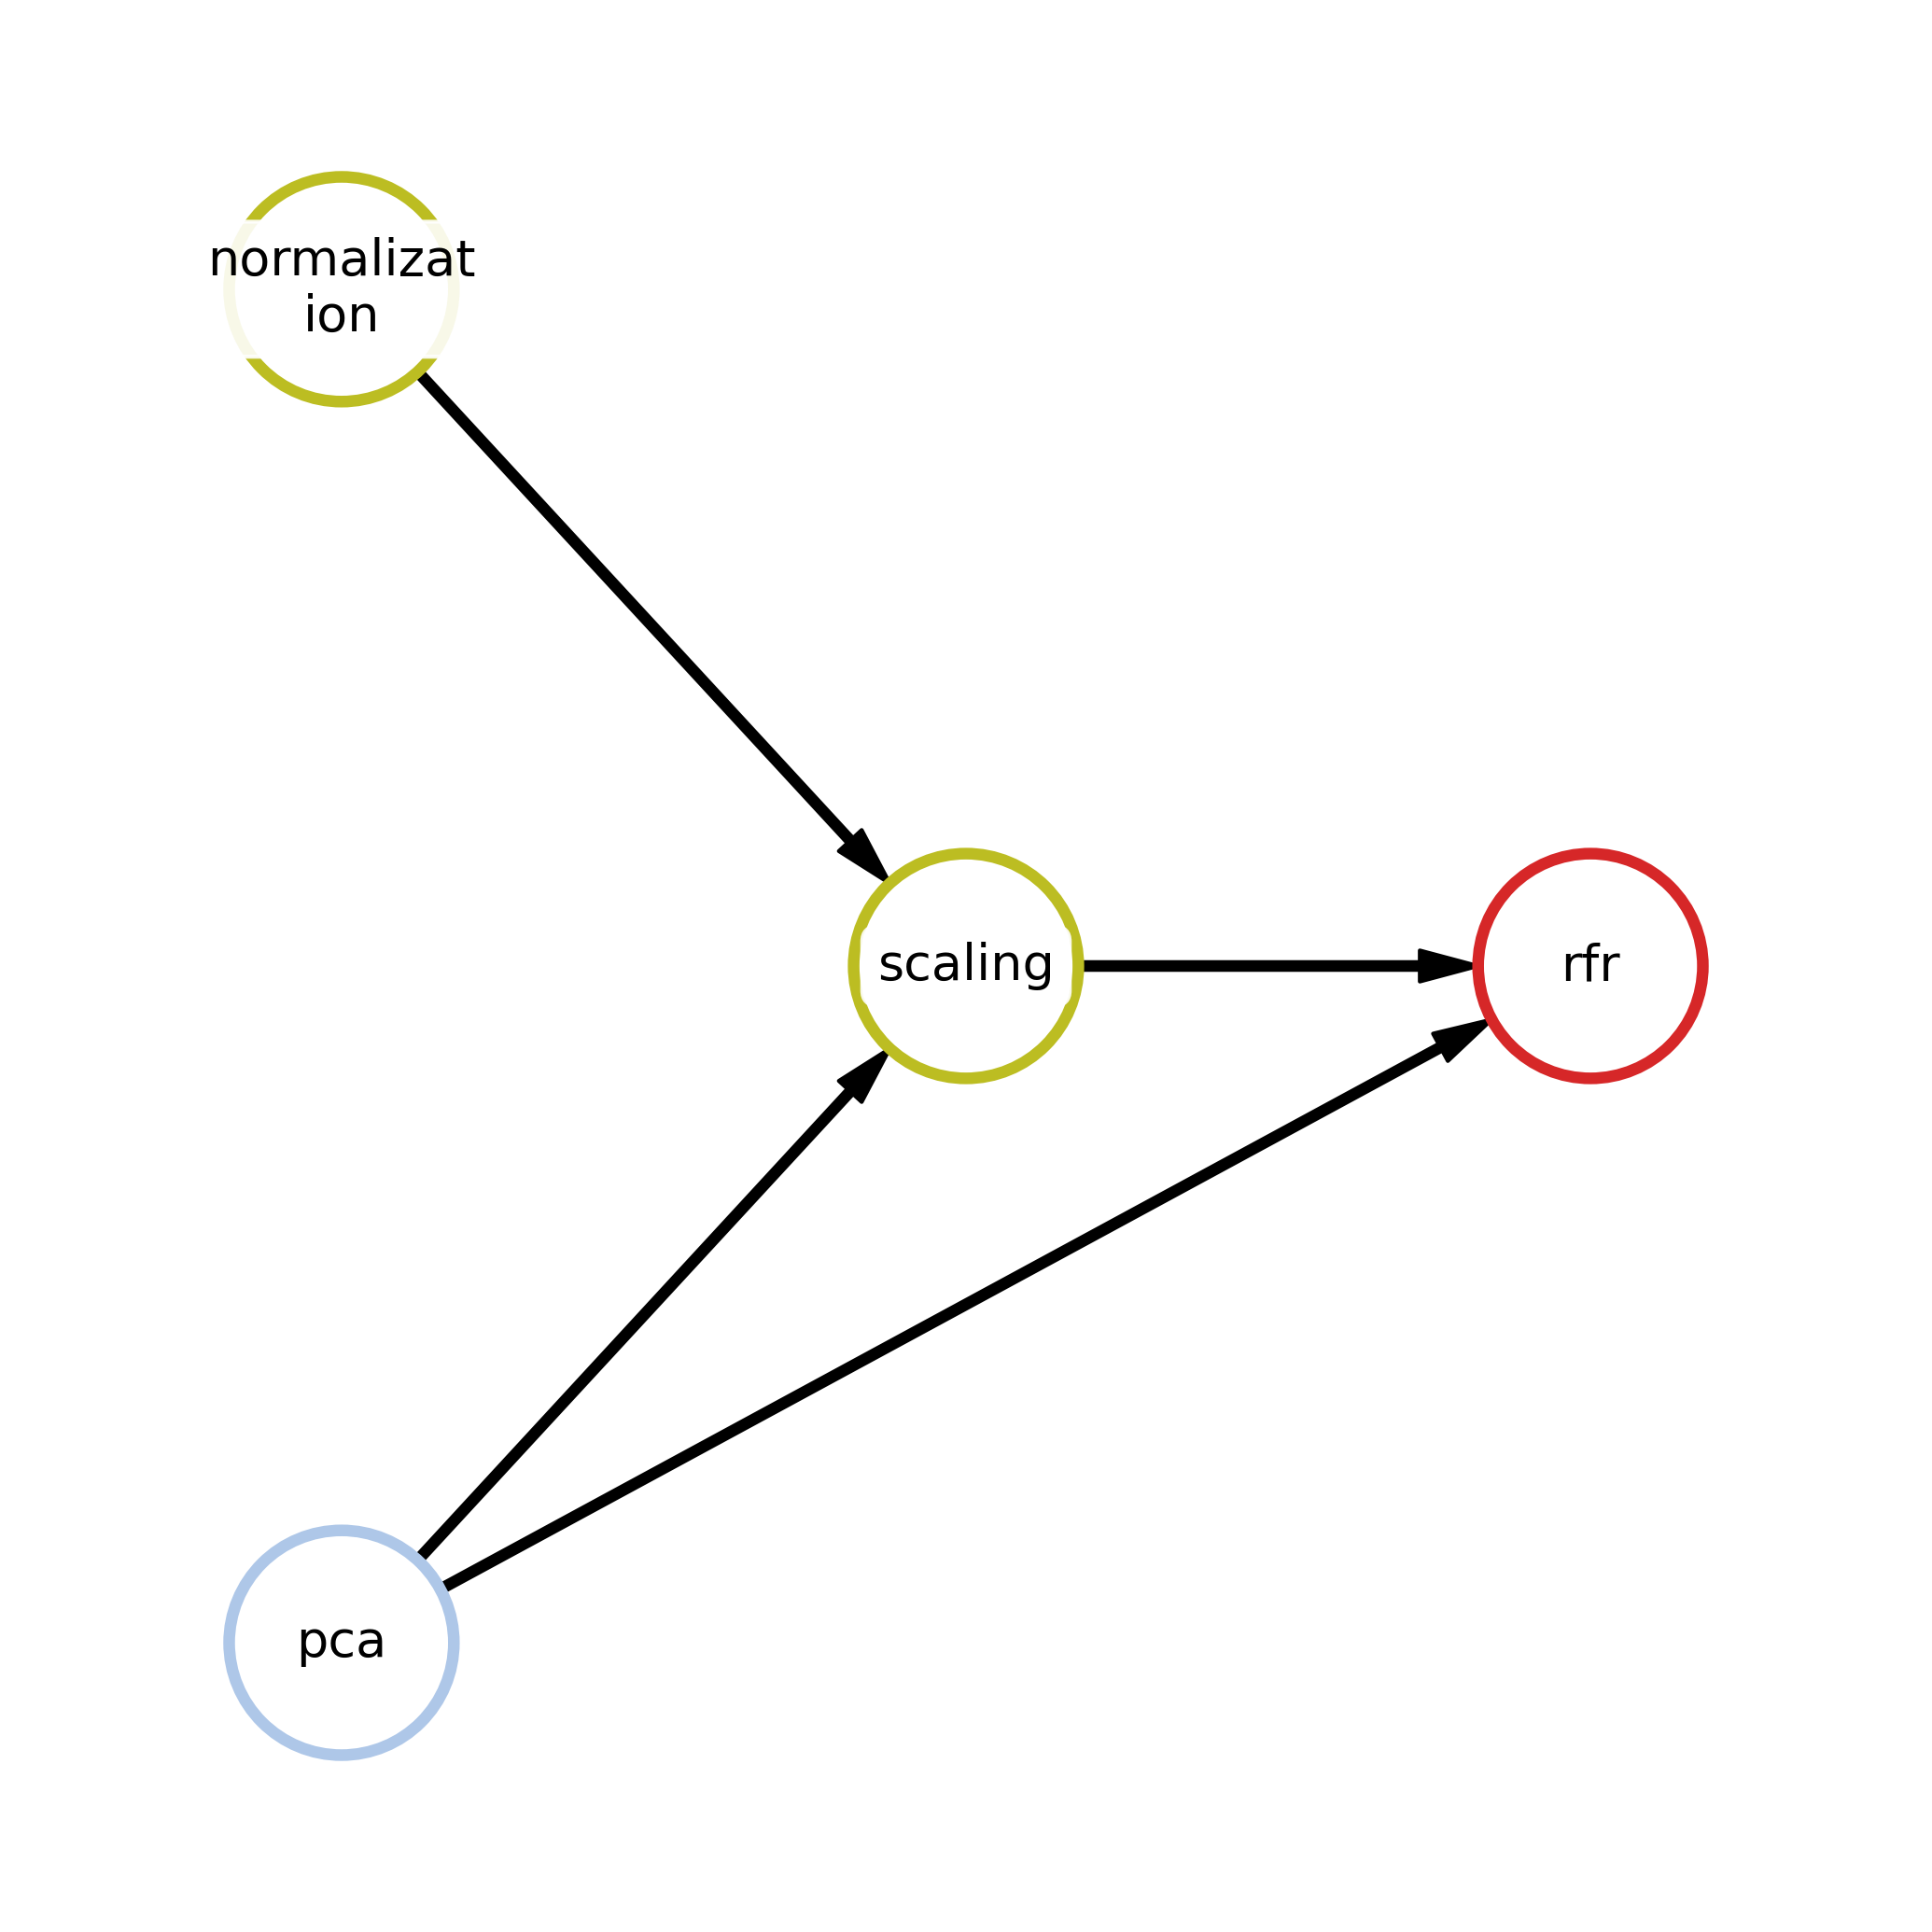

In [71]:
model = Fedot(problem='regression', timeout=10, n_jobs=-1)
obtained_pipeline = model.fit(features=X, target=y)
obtained_pipeline.show()


In [65]:
X[21]

array([3.67e+01, 2.45e+00, 2.13e+01, 9.30e+01, 2.40e+01, 6.50e+00,
       1.02e+01, 3.20e-01, 1.83e+01, 0.00e+00, 3.00e+00, 7.60e+02,
       1.20e+01, 3.64e+01, 7.10e-01, 3.00e+01, 6.80e+01, 1.90e+01,
       4.40e+00, 1.10e+01, 2.20e-01, 9.20e+00, 0.00e+00, 2.00e+00,
       4.62e+02, 1.36e+01, 3.65e+01, 1.91e+00, 1.96e+01, 7.30e+01,
       2.00e+01, 5.60e+00, 1.06e+01, 1.80e-01, 1.82e+01, 0.00e+00,
       5.00e+00, 3.86e+02, 1.26e+01])

In [73]:
y[21]

36.5

In [74]:
y_pred = model.predict(X)

In [76]:
from sklearn.metrics import r2_score
r2_res = r2_score(y, y_pred)

ValueError: Input contains NaN.